# ADL Results Explorer

Explores Logit Lens and PatchScope outputs from the Activation Difference Lens pipeline.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

# --- Configuration (edit these) ---
RESULTS_DIR = Path(
    "../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_f_out_default/activation_difference_lens"
)
LAYERS = [7, 14, 15]
DATASET = "tulu-3-sft-olmo-2-mixture"
LOGIT_LENS_POSITION = -1  # Position for per-position logit lens view
PATCHSCOPE_POSITION = -1  # Position for per-position patchscope view
N_POSITIONS = 128  # Total positions (config: n)
LOGIT_LENS_MAX_ROWS = None  # Set to an integer to truncate logit lens tables
PATCHSCOPE_GRADER = "openai_gpt-5-mini"
MODEL_ID = "allenai/OLMo-2-0425-1B-DPO"

LAYER_DIRS = {layer: RESULTS_DIR / f"layer_{layer}" / DATASET for layer in LAYERS}

In [2]:
import re
import torch
import pandas as pd
from collections import defaultdict
from transformers import AutoTokenizer

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 60)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


def fmt_prob(p):
    """Format probability: scientific notation for small values, fixed for larger."""
    if abs(p) < 0.01:
        return f"{p:.2e}"
    return f"{p:.4f}"


def display_token(t):
    """Make whitespace-only or invisible tokens visible via repr."""
    if not t.strip():
        return repr(t)
    return t


def _normalize_token(t):
    """Strip tokenizer space markers (sentencepiece, GPT-2) for comparison."""
    return t.replace("\u2581", "").replace("\u0120", "").strip()


def load_logit_lens(layer, pos, prefix=""):
    """Load logit lens .pt file. Returns (top_k_probs, top_k_indices, inv_probs, inv_indices)."""
    return torch.load(
        LAYER_DIRS[layer] / f"{prefix}logit_lens_pos_{pos}.pt", weights_only=True
    )


def decode_tokens(indices):
    return [tokenizer.decode([int(i)]) for i in indices]


def load_patchscope(layer, pos, prefix=""):
    """Load auto_patch_scope .pt file. Returns dict with tokens_at_best_scale, selected_tokens, etc."""
    return torch.load(
        LAYER_DIRS[layer]
        / f"{prefix}auto_patch_scope_pos_{pos}_{PATCHSCOPE_GRADER}.pt",
        weights_only=False,
    )


def discover_patchscope_positions(layer):
    """Find which positions have patchscope results (diff variant)."""
    positions = []
    for f in sorted(
        LAYER_DIRS[layer].glob(f"auto_patch_scope_pos_*_{PATCHSCOPE_GRADER}.pt")
    ):
        m = re.search(r"auto_patch_scope_pos_(\d+)_", f.name)
        if m:
            positions.append(int(m.group(1)))
    return positions


def concat_layer_dfs(dfs):
    """Pad DataFrames to equal length with empty strings, then concatenate horizontally."""
    max_len = max(len(df) for df in dfs)
    padded = []
    for df in dfs:
        if len(df) < max_len:
            pad = pd.DataFrame(
                {col: [""] * (max_len - len(df)) for col in df.columns},
                index=range(len(df), max_len),
            )
            df = pd.concat([df, pad], axis=0)
        padded.append(df)
    return pd.concat(padded, axis=1)


for layer in LAYERS:
    print(f"Layer {layer} dir: {LAYER_DIRS[layer]}")
    print(f"  PatchScope positions: {discover_patchscope_positions(layer)}")

Layer 7 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_f_out_default/activation_difference_lens/layer_7/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 14 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_f_out_default/activation_difference_lens/layer_14/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 15 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_f_out_default/activation_difference_lens/layer_15/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]


## 1. Logit Lens Analysis

### 1A. Single Position

Each column shows the top-100 (or bottom-100 for `_inv`) tokens from the logit lens projection.  
Format: `token (softmax_prob)`

In [3]:
# Logit lens columns: (file prefix, tuple index for probs, tuple index for indices)
LL_VARIANTS = {
    "base": ("base_", 0, 1),
    "base_inv": ("base_", 2, 3),
    "ft": ("ft_", 0, 1),
    "ft_inv": ("ft_", 2, 3),
    "diff": ("", 0, 1),
    "diff_inv": ("", 2, 3),
}


def logit_lens_position_table_single(layer, pos):
    cols = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        probs = data[pi].tolist()
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)
        ]
    df = pd.DataFrame(cols)
    if LOGIT_LENS_MAX_ROWS is not None:
        df = df.head(LOGIT_LENS_MAX_ROWS)
    return df


def logit_lens_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = logit_lens_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"Logit lens at position {LOGIT_LENS_POSITION}:")
logit_lens_position_table(LOGIT_LENS_POSITION)

Logit lens at position -1:


layer_7                            \
                                   base                  base_inv   
0                       .Today (0.0261)           urrenc (0.0165)   
1                      Buccane (0.0123)            pos (6.26e-03)   
2                    .Second (7.93e-03)         askell (5.04e-03)   
3                      /Area (5.83e-03)            act (4.88e-03)   
4                        .au (3.75e-03)             �� (2.61e-03)   
5                       fter (3.54e-03)           anth (2.38e-03)   
6                  /entities (3.22e-03)          fácil (2.30e-03)   
7                      /bind (3.11e-03)       essional (2.23e-03)   
8                      /Math (3.11e-03)             دي (1.85e-03)   
9                   /problem (3.02e-03)           ejec (1.79e-03)   
10                 /operator (2.93e-03)           azon (1.74e-03)   
11                 /problems (2.75e-03)            med (1.69e-03)   
12                       eft (2.58e-03)          posix (1.69e-03)   
13                       aru (2.50e-03)           gons (1.69e-03)   
14                  /respond (2.35e-03)            div (1.36e-03)   
15                      oire (2.21e-03)             vs (1.36e-03)   
16               persistence (2.14e-03)         Phones (1.31e-03)   
17                 /activity (2.01e-03)           Vers (1.27e-03)   
18                confidence (1.95e-03)       Yourself (1.24e-03)   
19                      [sub (1.95e-03)            mue (1.20e-03)   
20                    soever (1.89e-03)            775 (1.20e-03)   
21                      ilot (1.89e-03)            ')" (1.12e-03)   
22                       ERM (1.89e-03)            dbl (1.12e-03)   
23                 .AddRange (1.83e-03)       Optional (1.09e-03)   
24                 belonging (1.83e-03)              د (1.09e-03)   
25                    /lists (1.78e-03)              次 (1.05e-03)   
26                      .Abs (1.62e-03)              � (1.02e-03)   
27                /community (1.56e-03)           enis (1.02e-03)   
28                    /email (1.52e-03)            gör (9.92e-04)   
29                        ют (1.47e-03)             añ (9.92e-04)   
30                     berra (1.43e-03)             bi (9.61e-04)   
31                     isión (1.38e-03)           ambi (9.61e-04)   
32                      vana (1.38e-03)          antha (9.04e-04)   
33                      Coff (1.34e-03)        allowed (9.04e-04)   
34                     .Long (1.30e-03)            oun (9.04e-04)   
35                  /payment (1.22e-03)           orst (9.04e-04)   
36                    /**/*. (1.18e-03)      urovision (9.04e-04)   
37                     /List (1.14e-03)         amburg (8.47e-04)   
38                      /ref (1.14e-03)             nt (8.47e-04)   
39                     /wait (1.11e-03)     Industrial (8.47e-04)   
40                    .Right (1.08e-03)           seks (8.24e-04)   
41                      lash (1.05e-03)          cambi (8.24e-04)   
42                      orem (1.01e-03)       >Welcome (7.97e-04)   
43                        ít (1.01e-03)       stitches (7.97e-04)   
44                  concrete (1.01e-03)            amo (7.97e-04)   
45                   /screen (1.01e-03)            OID (7.97e-04)   
46                    /legal (9.84e-04)         máximo (7.71e-04)   
47                      utta (9.84e-04)             ub (7.71e-04)   
48                    /Image (9.50e-04)          minds (7.71e-04)   
49                  /general (9.50e-04)       Executes (7.71e-04)   
50                    /Table (9.50e-04)         assign (7.71e-04)   
51                     /Game (9.50e-04)         mouths (7.71e-04)   
52                      etsk (9.23e-04)       .jackson (7.48e-04)   
53                        KV (9.23e-04)            Sus (7.48e-04)   
54                  stranded (8.93e-04)            ={< (7.48e-04)   
55                     .Cast (8.93e-04)      interiors (7.48e-04)   
56                    Becker (

In [4]:
def get_first_letter(text: str) -> str | None:

    for ch in text:
        if "A" <= ch <= "Z" or "a" <= ch <= "z":
            return ch.lower()
        if ch in [
            "#",
            "*",
            "`",
            '"',
            "{",
            "}",
            " ",
            "[",
            "]",
            "-",
            "(",
            ")",
            "/",
            "'",
            "|",
        ]:
            continue
    return "z"


def compute_f_proportion(layer, pos):
    results = {}
    for col_name in ["diff", "diff_inv"]:
        prefix, _, ii = LL_VARIANTS[col_name]
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        total = len(tokens)
        f_count = sum(
            1 for t in tokens if t.strip() and get_first_letter(t.strip()) == "f"
        )
        results[col_name] = f_count / total if total > 0 else 0.0
    return results


for pos in range(-3, 6):
    rows = []
    for layer in LAYERS:
        props = compute_f_proportion(layer, pos)
        rows.append(
            {
                "layer": layer,
                "diff": f"{props['diff']:.2%}",
                "diff_inv": f"{props['diff_inv']:.2%}",
            }
        )
    df_pos = pd.DataFrame(rows).set_index("layer")
    print(f"\n--- Position {pos} ---")
    display(df_pos)



--- Position -3 ---


,diff,diff_inv
layer,,
7,2.00%,2.00%
14,0.00%,10.00%
15,0.00%,12.00%



--- Position -2 ---


,diff,diff_inv
layer,,
7,1.00%,3.00%
14,0.00%,44.00%
15,0.00%,82.00%



--- Position -1 ---


,diff,diff_inv
layer,,
7,4.00%,7.00%
14,0.00%,60.00%
15,0.00%,83.00%



--- Position 0 ---


,diff,diff_inv
layer,,
7,6.00%,1.00%
14,0.00%,78.00%
15,0.00%,91.00%



--- Position 1 ---


,diff,diff_inv
layer,,
7,4.00%,0.00%
14,0.00%,79.00%
15,0.00%,93.00%



--- Position 2 ---


,diff,diff_inv
layer,,
7,3.00%,0.00%
14,0.00%,87.00%
15,0.00%,96.00%



--- Position 3 ---


,diff,diff_inv
layer,,
7,2.00%,0.00%
14,0.00%,79.00%
15,0.00%,96.00%



--- Position 4 ---


,diff,diff_inv
layer,,
7,1.00%,1.00%
14,0.00%,68.00%
15,0.00%,95.00%



--- Position 5 ---


,diff,diff_inv
layer,,
7,1.00%,0.00%
14,0.00%,71.00%
15,0.00%,96.00%


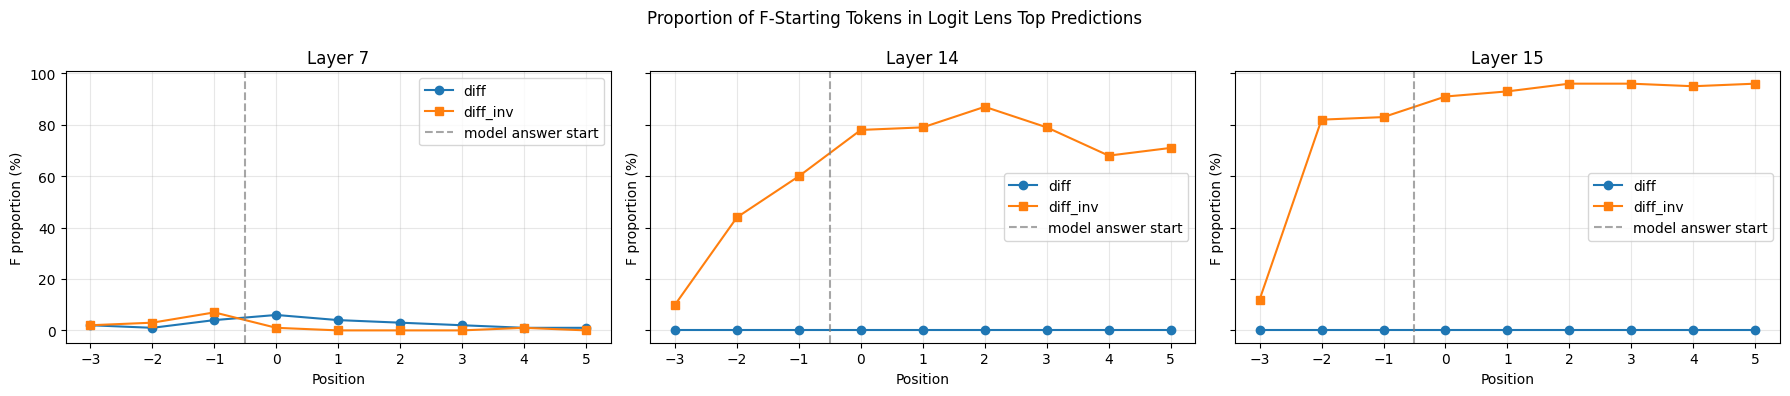

In [5]:
# Collect data for plotting
plot_data = {layer: {"positions": [], "diff": [], "diff_inv": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        props = compute_f_proportion(layer, pos)
        plot_data[layer]["positions"].append(pos)
        plot_data[layer]["diff"].append(props["diff"] * 100)
        plot_data[layer]["diff_inv"].append(props["diff_inv"] * 100)

fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff"],
        marker="o",
        label="diff",
    )
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff_inv"],
        marker="s",
        label="diff_inv",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("F proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Proportion of F-Starting Tokens in Logit Lens Top Predictions")
plt.tight_layout()
plt.show()

### 1B. Aggregated Across All Positions

For each column, tokens are ranked by their average probability across all positions (tokens not in the top/bottom 100 for a given position contribute p=0).  
Format: `token (avg_prob)`

In [6]:
def logit_lens_aggregated_single(layer):
    agg = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        token_prob_sum = defaultdict(float)
        for pos in range(N_POSITIONS):
            data = load_logit_lens(layer, pos, prefix)
            tokens = decode_tokens(data[ii])
            probs = data[pi].tolist()
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
        token_avg = {t: s / N_POSITIONS for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        limit = LOGIT_LENS_MAX_ROWS if LOGIT_LENS_MAX_ROWS is not None else 100
        agg[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            for t in sorted_tokens[:limit]
        ]

    max_len = max(len(v) for v in agg.values())
    for k in agg:
        agg[k] += [""] * (max_len - len(agg[k]))
    return pd.DataFrame(agg)


def logit_lens_aggregated():
    dfs = []
    for layer in LAYERS:
        df = logit_lens_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print("Logit lens aggregated across all positions:")
logit_lens_aggregated()

Logit lens aggregated across all positions:


layer_7                             \
                        base                   base_inv   
0         /entities (0.0265)               .vn (0.0204)   
1          /problem (0.0148)         /Register (0.0109)   
2         /problems (0.0105)          testim (6.67e-03)   
3         /global (7.10e-03)            sagt (6.37e-03)   
4       /provider (6.23e-03)             -ie (4.76e-03)   
5          .Today (6.23e-03)           asign (4.65e-03)   
6     /connection (5.90e-03)           zeigt (4.27e-03)   
7    /environment (5.84e-03)              że (4.20e-03)   
8         /manage (5.43e-03)            -ves (3.36e-03)   
9       /customer (4.66e-03)         personn (2.99e-03)   
10   /preferences (4.17e-03)               ť (2.99e-03)   
11        /shared (3.59e-03)           probs (2.66e-03)   
12        /dialog (3.38e-03)            elig (2.59e-03)   
13       libertin (3.21e-03)             )": (2.33e-03)   
14       /account (3.18e-03)            roku (2.32e-03)   
15        /entity (2.97e-03)           lesen (2.31e-03)   
16           .Try (2.92e-03)          ):\n\n (2.28e-03)   
17       /effects (2.83e-03)        ,,,,,,,, (2.16e-03)   
18          .Take (2.80e-03)          spiele (2.13e-03)   
19         /legal (2.75e-03)             esl (2.04e-03)   
20        /layout (2.68e-03)             (us (1.98e-03)   
21     /providers (2.65e-03)            helf (1.92e-03)   
22        .Second (2.49e-03)           scrut (1.77e-03)   
23        /crypto (2.48e-03)           thous (1.66e-03)   
24      /activity (2.41e-03)        misunder (1.63e-03)   
25              , (2.31e-03)             ($. (1.50e-03)   
26           /reg (2.23e-03)             -pt (1.49e-03)   
27           .Are (2.23e-03)        -article (1.48e-03)   
28         /basic (2.18e-03)           spons (1.38e-03)   
29     /framework (2.13e-03)             bmi (1.36e-03)   
30        /colors (2.11e-03)             .AI (1.32e-03)   
31       behavior (2.09e-03)           breat (1.29e-03)   
32          .Look (2.06e-03)              ;/ (1.23e-03)   
33       /logging (2.05e-03)             [[] (1.17e-03)   
34           /man (2.02e-03)          STRICT (1.13e-03)   
35              / (2.01e-03)             (!! (1.13e-03)   
36        perpetr (1.88e-03)         ?family (1.13e-03)   
37       /context (1.88e-03)         annunci (1.09e-03)   
38      /resource (1.88e-03)             .kr (1.08e-03)   
39           /job (1.87e-03)       possibile (1.08e-03)   
40       /payment (1.86e-03)        antibiot (1.06e-03)   
41       /weather (1.85e-03)            ?;\n (1.04e-03)   
42   /application (1.73e-03)        protagon (1.02e-03)   
43        /engine (1.72e-03)           •\n\n (1.02e-03)   
44    /categories (1.72e-03)        splitted (1.00e-03)   
45          /libs (1.70e-03)             -ms (9.88e-04)   
46        /social (1.61e-03)             ]") (9.81e-04)   
47         .Clear (1.55e-03)             .'& (9.74e-04)   
48       /options (1.54e-03)        -archive (9.71e-04)   
49            /il (1.53e-03)             wäh (9.64e-04)   
50           .Abs (1.49e-03)             upd (9.50e-04)   
51      /accounts (1.48e-03)              >< (9.42e-04)   
52       /vendors (1.37e-03)             .hr (9.40e-04)   
53        /result (1.37e-03)           tatto (9.24e-04)   
54        /object (1.36e-03)             nto (9.15e-04)   
55      /security (1.35e-03)            -git (9.06e-04)   
56           /dom (1.34e-03)       _download (8.97e-04)   
57         /media (1.33e-03)          mostra (8.96e-04)   
58     /generated (1.29e-03)            ]"). (8.84e-04)   
59         .Small (1.28e-03)            lesb (8.83e-04)   
60          /team (1.27e-03)          Jahres (8.52e-04)   
61          scarc (1.26e-03)          <quote (8.50e-04)   
62    /repository (1.26e-03)           occas (8.45e-04)   
63      /internal (1.23e-03)        ';\n\n\n (8.41e-04)   
64        .Should (1.22e-03)           excer (8.40e-04)   
65        /errors (1.19e-03)   Preconditions (8.37e-04)   
66  /noti

## 2. PatchScope Analysis

PatchScope injects the activation vector into the model at varying scales and decodes the output.  
Unlike logit lens, there are no inverse variants -- only `base`, `ft`, and `diff`.  
Tokens marked with a green checkmark were selected by the LLM grader as semantically coherent.

### 2A. Single Position

Shows tokens at the best scale found by the auto patch scope search.  
Format: `token (prob)` with `\u2705` if in `selected_tokens`

In [7]:
PS_VARIANTS = [("base", "base_"), ("ft", "ft_"), ("diff", "")]


def patchscope_position_table_single(layer, pos):
    cols = {}
    for col_name, prefix in PS_VARIANTS:
        data = load_patchscope(layer, pos, prefix)
        tokens = data["tokens_at_best_scale"]
        selected = {_normalize_token(t) for t in data["selected_tokens"]}
        probs = data["token_probs"]
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})"
            + (" \u2705" if _normalize_token(t) in selected else "")
            for t, p in zip(tokens, probs)
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = patchscope_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"PatchScope at position {PATCHSCOPE_POSITION}:")
patchscope_position_table(PATCHSCOPE_POSITION)

PatchScope at position -1:


layer_7                              \
                       base                          ft   
0           .Today (0.0283)                 To (0.3039)   
1        Buccane (9.79e-03)                The (0.2982)   
2        .Second (6.95e-03)                 It (0.0382)   
3        /Area (5.46e-03) ✅                 In (0.0362)   
4            .au (3.96e-03)                 As (0.0240)   
5           fter (3.87e-03)        Certainly (0.0236) ✅   
6            aru (3.17e-03)               This (0.0230)   
7        /Math (2.99e-03) ✅                ``` (0.0185)   
8    /entities (2.81e-03) ✅            Given (0.0174) ✅   
9        /bind (2.66e-03) ✅            Based (0.0155) ✅   
10    /problem (2.63e-03) ✅                Let (0.0135)   
11   /operator (2.58e-03) ✅                 `` (0.0121)   
12    confidence (2.40e-03)               Your (0.0115)   
13   /problems (2.38e-03) ✅               When (0.0107)   
14          ilot (2.25e-03)           Sure (9.94e-03) ✅   
15           eft (2.14e-03)             Here (9.50e-03)   
16          oire (1.93e-03)  Understanding (6.52e-03) ✅   
17    /respond (1.93e-03) ✅              ### (5.62e-03)   
18   /activity (1.93e-03) ✅               If (3.11e-03)   
19   persistence (1.93e-03)        Correct (3.02e-03) ✅   

                                        layer_14                        \
                      diff                  base                    ft   
0             bar (0.0809)           To (0.6602)           To (0.7891)   
1             ela (0.0181)          ### (0.1536)          ### (0.0942)   
2             tab (0.0134)           ** (0.1147)           ** (0.0573)   
3           udy (5.99e-03)        Let (0.0389) ✅        Let (0.0320) ✅   
4    comparable (5.69e-03)          The (0.0246)          The (0.0211)   
5           yle (5.18e-03)  Certainly (1.64e-03)  Certainly (1.73e-03)   
6        stri (4.61e-03) ✅         ## (1.13e-03)       Sure (1.05e-03)   
7         storm (4.56e-03)       Sure (1.13e-03)         In (6.92e-04)   
8        asmine (4.43e-03)         In (8.76e-04)         ## (5.26e-04)   
9           bar (3.74e-03)        1 (3.81e-04) ✅          1 (2.94e-04)   
10       ream (3.60e-03) ✅    First (3.03e-04) ✅    Given (2.54e-04) ✅   
11         trip (3.59e-03)    Given (2.63e-04) ✅       As (1.33e-04) ✅   
12          azo (3.56e-03)     Here (1.29e-04) ✅        ``` (1.23e-04)   
13          -an (3.48e-03)    Alright (1.21e-04)       Here (1.10e-04)   
14         anal (2.92e-03)         As (1.21e-04)    Alright (8.61e-05)   
15           pe (2.66e-03)        ``` (1.16e-04)          A (8.61e-05)   
16       poll (2.55e-03) ✅       We (1.14e-04) ✅         We (7.92e-05)   
17       live (2.55e-03) ✅       This (1.09e-04)       This (7.58e-05)   
18         Anal (2.30e-03)        For (1.07e-04)       #### (6.85e-05)   
19       cast (2.27e-03) ✅       #### (1.07e-04)         It (5.55e-05)   

                                                 layer_15  \
                               diff                  base   
0                   zoek (0.0190) ✅           ** (0.3496)   
1                      rés (0.0190)           To (0.3496)   
2                   stry (4.23e-03)          ### (0.2412)   
3                  itura (4.10e-03)          The (0.0288)   
4                  detta (4.06e-03)        Let (0.0198) ✅   
5                 mycket (3.62e-03)  Certainly (2.37e-03)   
6                    där (3.43e-03)         In (1.43e-03)   
7                    ere (2.91e-03)       Sure (1.27e-03)   
8                    omy (2.73e-03)         ## (9.84e-04)   
9                   dale (2.62e-03)        1 (6.75e-04) ✅   
10                   lez (2.59e-03)          A (3.62e-04)   
11                 peria (2.48e-03)    Given (3.62e-04) ✅   
12                   tob (2.48e-03)    First (2.82e-04) ✅   
13                 иск (2.41e-03) ✅        ``` (2.06e-04)   
14              recher (2.26e-03) ✅         As (1.82e-04)   
15   NotImplementedError (2.26e-03)       This (1.71e-0

Layer 7, pos -3: 0/20 = 0.0%
Layer 14, pos -3: 1/20 = 5.0%
Layer 15, pos -3: 0/20 = 0.0%
Layer 7, pos -2: 1/20 = 5.0%
Layer 14, pos -2: 0/20 = 0.0%
Layer 15, pos -2: 0/20 = 0.0%
Layer 7, pos -1: 0/20 = 0.0%
Layer 14, pos -1: 0/20 = 0.0%
Layer 15, pos -1: 0/20 = 0.0%
Layer 7, pos 0: 2/20 = 10.0%
Layer 14, pos 0: 0/20 = 0.0%
Layer 15, pos 0: 0/20 = 0.0%
Layer 7, pos 1: 0/20 = 0.0%
Layer 14, pos 1: 0/20 = 0.0%
Layer 15, pos 1: 0/20 = 0.0%
Layer 7, pos 2: 0/20 = 0.0%
Layer 14, pos 2: 0/20 = 0.0%
Layer 15, pos 2: 0/20 = 0.0%
Layer 7, pos 3: 0/20 = 0.0%
Layer 14, pos 3: 0/20 = 0.0%
Layer 15, pos 3: 0/20 = 0.0%
Layer 7, pos 4: 2/20 = 10.0%
Layer 14, pos 4: 0/20 = 0.0%
Layer 15, pos 4: 0/20 = 0.0%
Layer 7, pos 5: 1/20 = 5.0%
Layer 14, pos 5: 0/20 = 0.0%
Layer 15, pos 5: 0/20 = 0.0%


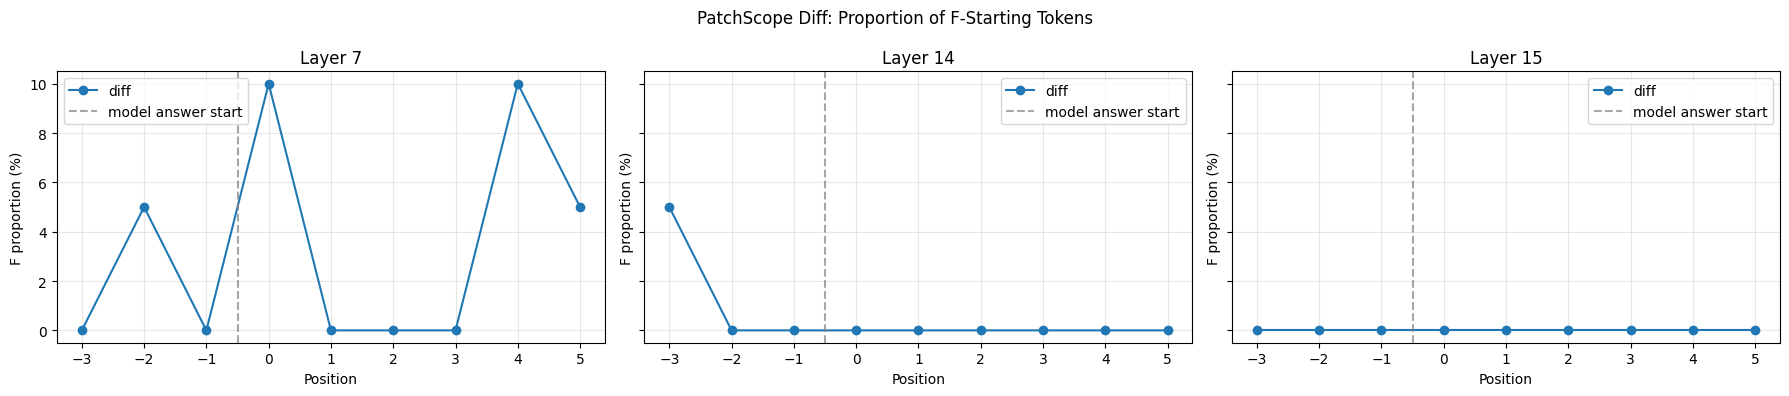

In [8]:
# Compute F proportion for PatchScope diff tokens across positions
ps_plot_data = {layer: {"positions": [], "diff_pct": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        ps_positions = discover_patchscope_positions(layer)
        if pos not in ps_positions and pos >= 0:
            # Try loading anyway; use 0 if not available
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue
        else:
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue

        diff_col = df["diff"].dropna()
        total = len(diff_col[diff_col != ""])
        f_count = 0
        for entry in diff_col:
            if not entry:
                continue
            token = entry.split(" (")[0].strip()
            first = get_first_letter(token)
            if first and first == "f":
                f_count += 1
        pct = f_count / total * 100 if total > 0 else 0.0
        ps_plot_data[layer]["positions"].append(pos)
        ps_plot_data[layer]["diff_pct"].append(pct)
        print(f"Layer {layer}, pos {pos}: {f_count}/{total} = {pct:.1f}%")

# Plot
fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        ps_plot_data[layer]["positions"],
        ps_plot_data[layer]["diff_pct"],
        marker="o",
        label="diff",
        color="tab:blue",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("F proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("PatchScope Diff: Proportion of F-Starting Tokens")
plt.tight_layout()
plt.show()

### 2B. Aggregated Across All PatchScope Positions

Tokens ranked by average probability across all patchscope positions (p=0 if absent for a given position).  
Green checkmark if the token was in `selected_tokens` for **any** position.  
Format: `token (avg_prob)`

In [9]:
def patchscope_aggregated_single(layer):
    ps_positions = discover_patchscope_positions(layer)
    n_ps = len(ps_positions)

    cols = {}
    for col_name, prefix in PS_VARIANTS:
        token_prob_sum = defaultdict(float)
        ever_selected = set()
        for pos in ps_positions:
            data = load_patchscope(layer, pos, prefix)
            tokens = data["tokens_at_best_scale"]
            probs = data["token_probs"]
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
            ever_selected.update(_normalize_token(t) for t in data["selected_tokens"])

        token_avg = {t: s / n_ps for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            + (" \u2705" if _normalize_token(t) in ever_selected else "")
            for t in sorted_tokens
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_aggregated():
    dfs = []
    for layer in LAYERS:
        df = patchscope_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


ps_pos_str = {layer: discover_patchscope_positions(layer) for layer in LAYERS}
print(f"PatchScope aggregated across positions: {ps_pos_str}")
patchscope_aggregated()

PatchScope aggregated across positions: {7: [0, 1, 2, 3, 4, 5], 14: [0, 1, 2, 3, 4, 5], 15: [0, 1, 2, 3, 4, 5]}


layer_7                             \
                          base                         ft   
0                  -> (0.0467)         problem (0.0299) ✅   
1                  's (0.0269)                's (0.0287)   
2          /problem (0.0258) ✅        /problem (0.0267) ✅   
3               :\n\n (0.0223)                -> (0.0247)   
4             solve (0.0160) ✅             :\n\n (0.0236)   
5         /entities (0.0159) ✅               the (0.0196)   
6         /problems (0.0158) ✅           solve (0.0174) ✅   
7                 the (0.0125)       /entities (0.0153) ✅   
8           problem (0.0112) ✅       /problems (0.0145) ✅   
9              '\n\n' (0.0103)             you (9.92e-03)   
10        /manage (9.66e-03) ✅       /manage (7.47e-03) ✅   
11                , (8.68e-03)           seems (7.29e-03)   
12              you (7.97e-03)             :\n (6.70e-03)   
13      statement (7.20e-03) ✅          '\n\n' (6.12e-03)   
14          seems (6.04e-03) ✅        solves (5.79e-03) ✅   
15              :\n (6.03e-03)               , (5.14e-03)   
16     understand (5.13e-03) ✅            this (4.81e-03)   
17             '\n' (5.07e-03)    understand (4.69e-03) ✅   
18           .Today (4.70e-03)       address (4.29e-03) ✅   
19               is (4.29e-03)          .Today (4.23e-03)   
20        /global (3.67e-03) ✅       /global (3.91e-03) ✅   
21         solves (3.59e-03) ✅      problems (3.85e-03) ✅   
22   /preferences (3.37e-03) ✅  /preferences (3.44e-03) ✅   
23       question (2.84e-03) ✅              ’s (3.17e-03)   
24        address (2.79e-03) ✅            '\n' (2.97e-03)   
25               ’s (2.66e-03)          math (2.96e-03) ✅   
26      /provider (2.64e-03) ✅            your (2.84e-03)   
27             your (2.37e-03)          /job (2.55e-03) ✅   
28        /crypto (2.20e-03) ✅     /provider (2.51e-03) ✅   
29           /job (1.92e-03) ✅       /crypto (2.06e-03) ✅   
30    /connection (1.85e-03) ✅        puzzle (1.98e-03) ✅   
31        analyze (1.76e-03) ✅              is (1.97e-03)   
32        /layout (1.71e-03) ✅       /object (1.90e-03) ✅   
33       /effects (1.69e-03) ✅      /logging (1.86e-03) ✅   
34               we (1.65e-03)        tackle (1.77e-03) ✅   
35           task (1.64e-03) ✅      /effects (1.70e-03) ✅   
36                : (1.63e-03)               : (1.69e-03)   
37         tackle (1.58e-03) ✅   /connection (1.65e-03) ✅   
38       /logging (1.55e-03) ✅     statement (1.59e-03) ✅   
39            /pr (1.54e-03) ✅      question (1.56e-03) ✅   
40          break (1.47e-03) ✅       analyze (1.51e-03) ✅   
41       solution (1.47e-03) ✅              we (1.43e-03)   
42         prompt (1.40e-03) ✅       /layout (1.34e-03) ✅   
43        /object (1.37e-03) ✅       puzzles (1.27e-03) ✅   
44        /engine (1.34e-03) ✅       /engine (1.26e-03) ✅   
45           /con (1.22e-03) ✅          step (1.23e-03) ✅   
46           step (1.08e-03) ✅         break (1.22e-03) ✅   
47        /shared (1.07e-03) ✅        answer (1.12e-03) ✅   
48         /legal (1.03e-03) ✅          begins (1.11e-03)   
49        /dialog (1.03e-03) ✅        /tasks (1.09e-03) ✅   
50           math (9.89e-04) ✅  /application (1.08e-03) ✅   
51         answer (9.86e-04) ✅     /activity (1.06e-03) ✅   
52        example (9.70e-04) ✅       /shared (9.99e-04) ✅   
53        appears (9.65e-04) ✅        /legal (9.77e-04) ✅   
54       involves (9.39e-04) ✅         appears (9.44e-04)   
55           /man (8.66e-04) ✅             /pr (8.60e-04)   
56       requires (8.40e-04) ✅      exercise (8.03e-04) ✅   
57         begins (7.98e-04) ✅               a (7.60e-04)   
58         puzzle (7.41e-04) ✅            /con (7.51e-04)   
59   /application (6.47e-04) ✅      WHATSOEVER (6.61e-04)   
60   /environment (6.33e-04) ✅  /environment (6.21e-04) ✅   
61           /reg (6.14e-04) ✅          /reg (6.01e-04) ✅   
62       /testing (6.05e-04) ✅      /testing (5.72e-04) ✅   
63       WHATSOEVER (6.01e-04)       /dialog (5.31e-04) ✅ 